In [1]:
!pip install seaborn==0.9.0
!pip install allennlp==0.8.5
!pip install matplotlib
!pip install numpy 
!pip install ray

In [14]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import json

from matplotlib import pyplot as plt

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Basic Setup of grammar and global variables like serialization directory and training config file

In [162]:
FSA_GRAMMAR_STRING = """
                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]
                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]
                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]
                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]
                    """
    
os.environ["FSA_GRAMMAR_STRING"] = FSA_GRAMMAR_STRING
os.environ['ARTIFICIAL_GRAMMAR_TRAIN'] = ""
os.environ['ARTIFICIAL_GRAMMAR_DEV'] = ""

dataset_experiments_params = [(6250,16), (12500,8) , (25000, 4), (50000,2), (100000,1)]

num_sample_oracles = 10
num_trials = 10
num_samples_per_length=1000

# Ipython by default adds some arguments to sys.argv.
#  We don't want those arguments, hence we pass [] here.
#
# The deafult argument get_args is args=None. 
# This translates to parsing sys.argv. This is useful
# in case we run the method from a python file but not here.
# Hence, we keep the default argument as None but pass [] for 
# ipython notebook.
main_args = get_args(args=[])

serialization_dir = os.path.join(main_args.output_dir, datetime.now().strftime("%m_%d_%Y_%H_%M_%S"))
param_path = main_args.config

# Dataset Experiments

In [163]:
dataset_exp_results = json.load(open('results/artificial_grammar/10_12_2019_20_59_02/dataset_experiments.json'))
max_lens = 0
for num_samples in dataset_exp_results:
    arr = dataset_exp_results[num_samples]
    if max_lens < len(dataset_exp_results[num_samples]):
        max_lens = len(dataset_exp_results[num_samples])
print(max_lens)
for num_samples in dataset_exp_results:
    arr = dataset_exp_results[num_samples]
    padding = [None] * (max_lens - len(arr))
    dataset_exp_results[num_samples] = np.array(dataset_exp_results[num_samples] + padding)
dataset_exp_results = pd.DataFrame(dataset_exp_results)
dataset_exp_results

160


,1000,10000,25000,50000,100000
0,0.596143,0.280215,0.249035,0.195919,0.197986
1,0.761331,0.324122,0.182179,0.174089,0.216501
2,0.935175,0.394191,0.191587,0.229833,0.211204
3,0.638680,0.256959,0.255487,0.165874,0.211381
4,0.753216,0.301083,0.2179,0.195706,0.200609
...,...,...,...,...,...
155,0.598478,None,None,None,None
156,0.746466,None,None,None,None
157,0.774046,None,None,None,None
158,0.709010,None,None,None,None


Text(0, 0.5, 'Exposure Bias')

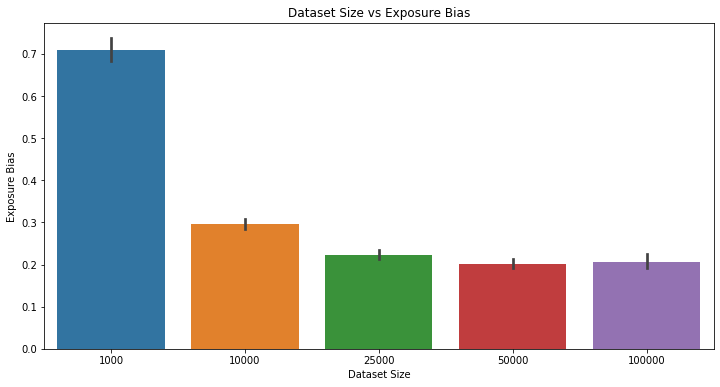

In [164]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(data=dataset_exp_results, ax=ax1)

plt.title('Dataset Size vs Exposure Bias')
ax1.set_xlabel('Dataset Size')
ax1.set_ylabel('Exposure Bias')



# Validation Experiments

In [288]:
result_file = 'results/artificial_grammar/10_12_2019_22_07_56/validation_experiments.json'
#result_file = 'results/artificial_grammar/10_12_2019_21_00_22/validation_experiments.json'
validation_exp_results = json.load(open(result_file))

# val_ppl_max_len = 0
# for epoch in validation_exp_results:
#     arr = validation_exp_results[epoch]['val_ppl']
#     if val_ppl_max_len < len(arr):
#         val_ppl_max_len = len(arr)

# for epoch in validation_exp_results:
#     arr = validation_exp_results[epoch]['val_ppl']
#     padding = [None] * (val_ppl_max_len - len(arr))
#     validation_exp_results[epoch]['val_ppl'] = np.array(validation_exp_results[epoch]['val_ppl'] + padding)

# exp_bias_max_len = 0
# for epoch in validation_exp_results:
#     arr = validation_exp_results[epoch]['exp_biases']
#     if exp_bias_max_len < len(arr):
#         exp_bias_max_len = len(arr)
    
# for epoch in validation_exp_results:
#     arr = validation_exp_results[epoch]['exp_biases']
#     padding = [None] * (exp_bias_max_len - len(arr))
#     validation_exp_results[epoch]['exp_biases'] = np.array(validation_exp_results[epoch]['exp_biases'] + padding)


for epoch in validation_exp_results:
    validation_exp_results[epoch]['exp_biases'] = np.array(validation_exp_results[epoch]['exp_biases'], dtype=float)
    validation_exp_results[epoch]['val_ppl'] = np.array(validation_exp_results[epoch]['val_ppl'], dtype=float)
    validation_exp_results[epoch]['exp_mean'] = np.mean(validation_exp_results[epoch]['exp_mean'], dtype=float)
    validation_exp_results[epoch]['exp_std'] = np.std(validation_exp_results[epoch]['exp_std'], dtype=float)
    validation_exp_results[epoch]['val_ppl_mean'] = np.mean(validation_exp_results[epoch]['val_ppl'], dtype=float)
    validation_exp_results[epoch]['val_ppl_std'] = np.std(validation_exp_results[epoch]['val_ppl'], dtype=float)

validation_exp_results = pd.DataFrame(validation_exp_results).T
validation_exp_results = validation_exp_results[:10]
validation_exp_results['exp_mean'] = validation_exp_results['exp_mean'].astype(float)
validation_exp_results['val_ppl_mean'] = validation_exp_results['val_ppl_mean'].astype(float)

# exp_biases = {}
# for key in validation_exp_results:
#     exp_biases[key] = validation_exp_results[key]['exp_biases']

# exp_biases_pd = pd.DataFrame(exp_biases)

# val_ppl = {}
# for key in validation_exp_results:
#     val_ppl[key] = np.mean(validation_exp_results[key]['val_ppl'])
# print(val_ppl)
# val_ppl_pd = pd.DataFrame(val_ppl, index=[0]).T

# exp_biases_pd.mean()
#val_ppl_pd
validation_exp_results['val_ppl_mean']

0    2.967610
1    2.955484
2    2.950575
3    2.947707
4    2.946920
5    2.945601
6    2.945073
7    2.941449
8    2.937429
9    2.948125
Name: val_ppl_mean, dtype: float64

2019-10-13 02:28:28,003 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2019-10-13 02:28:28,004 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2019-10-13 02:28:28,021 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2019-10-13 02:28:28,022 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


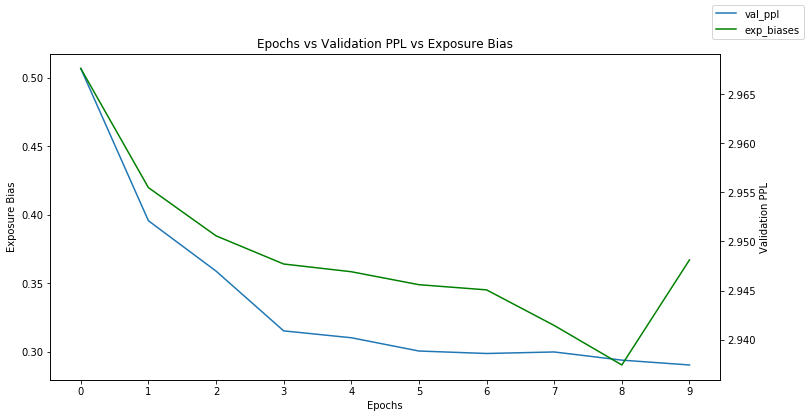

In [289]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111, label='exposure bias')

plt.title('Epochs vs Validation PPL vs Exposure Bias')
ax1.set_xlabel('Epochs')
#sns.boxplot(data=exp_biases_pd, ax=ax1)
#sns.lineplot(data=exp_biases_pd.T, ax=ax1, color='b', err_style='band')
sns.lineplot(data=validation_exp_results.exp_mean, ax=ax1)
#ax1.errorbar(x=validation_exp_results.index, y=validation_exp_results.exp_mean, color='g')

ax1.set_ylabel('Exposure Bias')

ax2 = ax1.twinx()
#ax2.errorbar(x=validation_exp_results.index, y=validation_exp_results.val_ppl_mean, color='r')
#sns.boxplot(data=val_ppl_pd, ax=ax2, palette='RdBu')
#sns.lineplot(data=val_ppl_pd, ax=ax2, color='g')
sns.lineplot(data=validation_exp_results.val_ppl_mean, ax=ax2, color='g')

ax2.set_ylabel('Validation PPL')
ax2.yaxis.set_label_position('right')


fig.legend(['val_ppl', 'exp_biases'])


# Model Size Experiments

# Beam Search Experiments